In [1]:
from congress_utils import congress_clsna, preprocess, make_ar_pair, member_dict, ClsnaModelCongress
from utils import visualize_membership, visualize
import numpy as np
import torch
import math
import matplotlib.pyplot as plt
from scipy.linalg import orthogonal_procrustes

In [2]:
# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter(log_dir='../runs/jweqiag', comment = "")

In [3]:
import time

In [4]:
N = 2000
DIM = 2
T = 10
SIGMA = 2
TAU = 0.5
PHI = 1
ALPHA = 1
DELTA = 2
GAMMAW = 0.5
GAMMAB = -0.5
N_LEAVE = 100

In [5]:
start = time.time()
z,y,persist,Aw,Ab,leaves=congress_clsna(N=N, d=DIM, T=T, alpha=ALPHA, delta=DELTA, sigma=SIGMA, tau=TAU , phi=PHI, gammaw=GAMMAW, gammab=GAMMAB, n_leave=N_LEAVE)
end = time.time()
print(end - start)

4.126705646514893


In [6]:
z = np.concatenate(z)
persist = np.concatenate(persist)

In [7]:
# for i in range(T-1):
#     corr = z[N*i:N*(i+1)].transpose()@z[N*(i+1):N*(i+2)]
# #     print(np.diag(corr.round(1)))
#     print(corr.round(1))

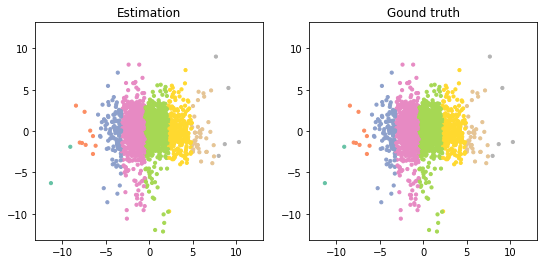

In [8]:
visualize(z_hat=z,z_true=z,start=N*9,end=N*10)

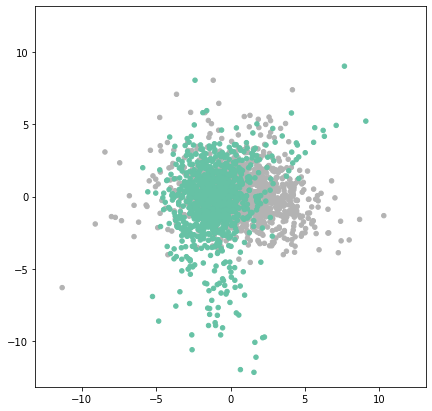

In [9]:
membership = np.concatenate((np.ones(N//2),np.zeros(N//2)))
visualize_membership(z=z,membership=np.tile(membership,T),start=9*N,end=10*N)

In [10]:
label, persist, Aw, Ab, combination_N=preprocess(y, Aw, Ab, N, T, persist)

In [11]:
label.sum()/label.size(0)

tensor(0.2290)

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = "cpu"

In [15]:
ar_pair = make_ar_pair(device,leaves,N,T)
new_at_t = member_dict(device,leaves,N,T)

In [16]:
combination_N = combination_N.to(device)
label = label.to(device)
persist = persist.to(device)

In [17]:
LR = 2e-3
MOM = 0.99
LR_P = 1e-2

In [56]:
# # check attractors ground truth
# step0z = torch.from_numpy(z).float()
# step0x1 = Aw@step0z[:(T-1)*N]
# step0x2 = Ab@step0z[:(T-1)*N]
# step0X = torch.stack((step0x1.flatten(), step0x2.flatten()))
# torch.inverse(step0X@step0X.t())*10000

tensor([[ 2.0646, -1.7545],
        [-1.7545,  1.7549]])

# Step 1

In [19]:
def train(optimizer,index=None, fixed=None):
    t_index=torch.arange(start=0,end=N*T,device=device,requires_grad=False)
    optimizer.zero_grad()
    loss = model.loss(device=device,label=label,persist=persist,sample_edge=combination_N,T_index=t_index,ss=SIGMA,tt=TAU,pp=PHI)
    loss.backward()
    model.para.grad = 0.1*((model.para.grad>0).bool().float()-0.5)
    optimizer.step()
    if index is not None:
        with torch.no_grad():
            model.para[index[0],index[1]] = fixed
    return loss.item()

In [ ]:
def check_alignment(zz):
    align = 1
    for i in range(T-1):
        d1=zz[N*i:N*(i+1)]
        d2=zz[N*(i+1):N*(i+2)]
        c1=d1-(d1.mean(axis=0))[np.newaxis,:]
        c2=d2-(d2.mean(axis=0))[np.newaxis,:]
        R,_ = orthogonal_procrustes(c1,c2)
        if not np.all(np.diag(R.round(1)) == 1):
            align = 0
            break
    return align

In [20]:
def run(optimizer):
    stop = 0
    last_loss = 0
    for epoch in range(1,200000000):
        loss = train(optimizer)
        #test information
        if stop>15:
            break
        if optimizer.param_groups[0]['lr']<1e-15:
            break
        if epoch%111==0:
            print(model.z.max())
            print(model.para)
            print(stop)
            print(loss)
            PCA_p = torch.pca_lowrank(model.z.cpu())[2][:,[0,1]]
            zz=(model.z.cpu().detach()@PCA_p).detach().numpy()
            align = check_alignment(zz)
            if align==1:
                stop = stop+1
            else:
                stop = 0
            
#         if epoch%111==0 and epoch>111111:
#             tt = epoch%T
#             print(torch.pca_lowrank(model.z.cpu()))
#             z_hat, p_hat = model()
#             z_hat = z_hat.detach().cpu().numpy()
#             p_hat = p_hat.detach().cpu().numpy().round(2)
#             caption_dict = {'E':epoch,
#                             'T':tt,
#                             'a':p_hat[0,1],
#                             'd':p_hat[2,1],
#                             'gw':p_hat[1,1],
#                             'gb':p_hat[2,0],
# #                             's':round(math.exp(p_hat[0,0])**0.5,1),
# #                             't':round(math.exp(p_hat[1,0])**0.5,1),
#                            'lr':round(optimizer.param_groups[0]['lr'],2),
#                            'loss':round(loss,1)}
#             start = tt*N
#             end = (tt+1)*N
#             visualize(z_hat=z_hat[:,:2],z_true=z[:,[1,0]],start=start,end=end,caption=str(caption_dict))            
            

In [25]:
model = ClsnaModelCongress(device,N,T,ar_pair,Aw,Ab,new_at_t,DIM+1).to(device)

In [26]:
optimizer = torch.optim.SGD([
    {'params': model.z, "momentum": 0.99, "lr": 0.002},
    {'params': model.para, "momentum": 0, "lr":1e-1}
    ])

In [27]:
run(optimizer)

tensor(11.9048, device='cuda:0', grad_fn=<MaxBackward1>)
Parameter containing:
tensor([[0.5550, 0.5450],
        [0.5550, 0.4050],
        [0.1750, 0.5550]], device='cuda:0', requires_grad=True)
0
8161518.663446112
tensor(12.9629, device='cuda:0', grad_fn=<MaxBackward1>)
Parameter containing:
tensor([[ 1.1100,  1.1000],
        [ 1.1100,  0.5800],
        [-0.3800,  1.1100]], device='cuda:0', requires_grad=True)
1
7095223.780069081
tensor(12.5902, device='cuda:0', grad_fn=<MaxBackward1>)
Parameter containing:
tensor([[ 1.6650,  1.3050],
        [ 1.6650,  0.5950],
        [-0.5250,  1.6650]], device='cuda:0', requires_grad=True)
2
6814853.446775969
tensor(9.4847, device='cuda:0', grad_fn=<MaxBackward1>)
Parameter containing:
tensor([[ 2.2200,  1.1500],
        [ 2.2200,  0.5500],
        [-0.5100,  1.9900]], device='cuda:0', requires_grad=True)
3
6755622.981193201
tensor(10.5324, device='cuda:0', grad_fn=<MaxBackward1>)
Parameter containing:
tensor([[ 2.7750,  1.1250],
        [ 2.7750

In [28]:
model.para

Parameter containing:
tensor([[ 8.8802,  1.1300],
        [ 8.8802,  0.5100],
        [-0.5100,  1.9900]], device='cuda:0', requires_grad=True)

tensor([297.5248, 287.9871,  61.7046], grad_fn=<LinalgSvdBackward0>)
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
------------
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
0
tensor([90.3775, 89.2609, 20.4339], grad_fn=<LinalgSvdBackward0>)


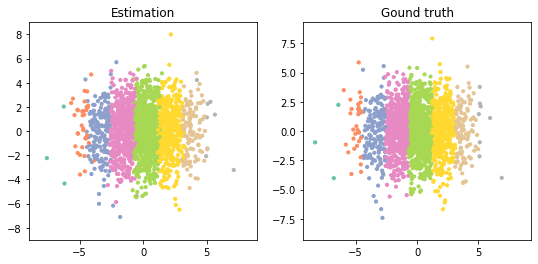

1
tensor([91.8121, 90.6078, 18.9939], grad_fn=<LinalgSvdBackward0>)


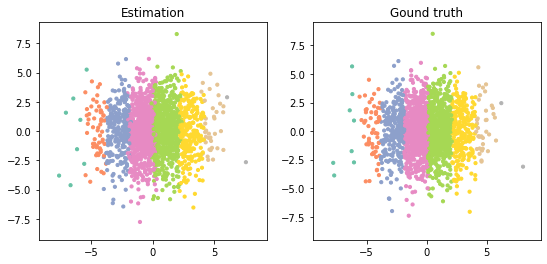

2
tensor([92.2830, 90.9692, 18.4566], grad_fn=<LinalgSvdBackward0>)


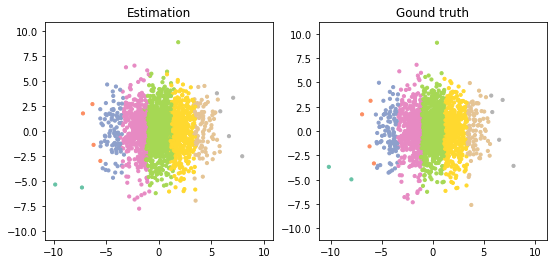

3
tensor([92.7628, 90.1677, 18.6635], grad_fn=<LinalgSvdBackward0>)


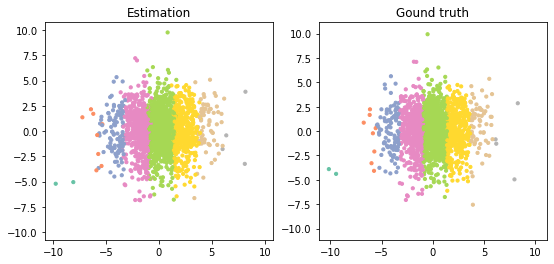

4
tensor([92.3559, 89.8580, 19.0980], grad_fn=<LinalgSvdBackward0>)


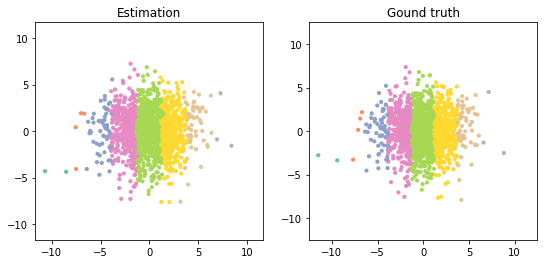

5
tensor([91.9792, 88.9827, 18.9859], grad_fn=<LinalgSvdBackward0>)


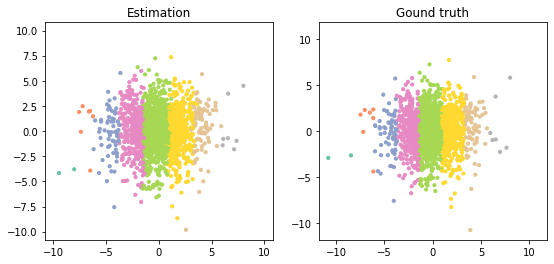

6
tensor([93.0106, 89.9263, 19.3774], grad_fn=<LinalgSvdBackward0>)


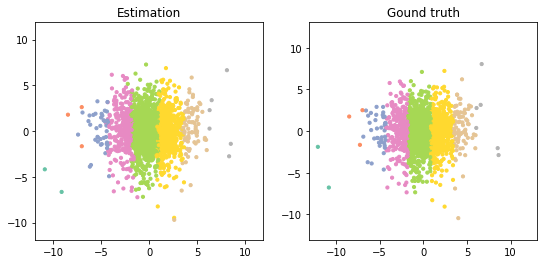

7
tensor([94.0139, 89.4639, 19.0497], grad_fn=<LinalgSvdBackward0>)


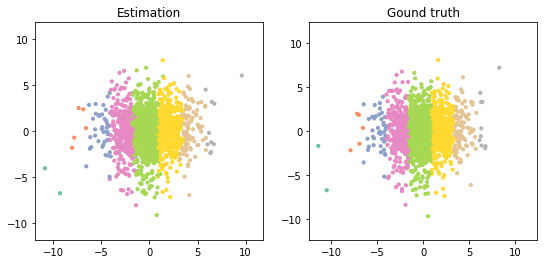

8
tensor([98.0048, 92.1836, 20.0640], grad_fn=<LinalgSvdBackward0>)


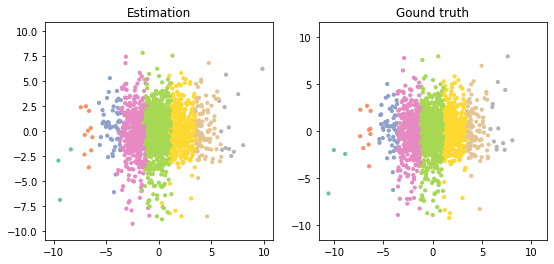

9
tensor([105.2690,  96.9030,  21.6784], grad_fn=<LinalgSvdBackward0>)


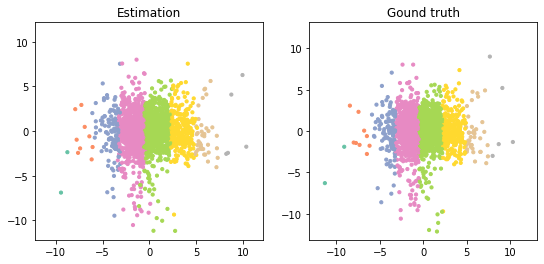

In [29]:
print(torch.pca_lowrank(model.z.cpu())[1])
PCA_p = torch.pca_lowrank(model.z.cpu())[2][:,[0,1]]
zz=(model.z.cpu().detach()@PCA_p).detach().numpy()
for i in range(T-1):
    R,_=orthogonal_procrustes(zz[N*i:N*(i+1)],zz[N*(i+1):N*(i+2)])
    print(np.diag(R.round(2)))
print('------------')
for i in range(T-2):
    R,_=orthogonal_procrustes(zz[N*i:N*(i+1)],zz[N*(i+2):N*(i+3)])
    print(np.diag(R.round(2)))
for i in range(T):
    B=torch.pca_lowrank(model.z.cpu()[i*N:(i+1)*N])[1]
    print(i)
    print(B)
    visualize(z_hat=zz,z_true=z[:,[0,1]],start=N*i,end=N*(i+1))
init_z = zz
init_para = model.para.detach().cpu().numpy()

In [30]:
for i in range(T-1):
    R,_=orthogonal_procrustes(z[N*i:N*(i+1)],z[N*(i+1):N*(i+2)])
    print(np.diag(R.round(2)))
print('------------')
TT = 9
for i in range(T-TT):
    R,_=orthogonal_procrustes(z[N*i:N*(i+1)],z[N*(i+TT):N*(i+TT+1)])
    print(np.diag(R.round(2)))

[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
------------
[1. 1.]


# Step 2

In [33]:
model = ClsnaModelCongress(device,N,T,ar_pair,Aw,Ab,new_at_t,DIM).to(device)
with torch.no_grad():       
    model.z[:,:] = torch.from_numpy(init_z).to(device)
    model.para[:,:] = torch.from_numpy(init_para).to(device)
optimizer = torch.optim.SGD([
    {'params': model.z, "momentum": MOM, "lr": LR},
    {'params': model.para, "momentum": 0.0, "lr":LR_P}
    ])

In [34]:
def run(optimizer):
    for epoch in range(1,2000):
        optimizer.param_groups[0]['lr'] = 0.0005

        if optimizer.param_groups[0]['lr']<0.00001:
            break
        loss = train(optimizer)
        if epoch%111==0:
            print(loss)
            print(model.para)
#         if epoch%1111==0 and epoch>111111:
#             tt = epoch%T
#             print(torch.pca_lowrank(model.z.cpu()))
#             z_hat, p_hat = model()
#             z_hat = z_hat.detach().cpu().numpy()
#             p_hat = p_hat.detach().cpu().numpy().round(2)
#             caption_dict = {'E':epoch,
#                             'T':tt,
#                             'a':p_hat[0,1],
#                             'd':p_hat[2,1],
#                             'gw':p_hat[1,1],
#                             'gb':p_hat[2,0],
# #                             's':round(math.exp(p_hat[0,0])**0.5,1),
# #                             't':round(math.exp(p_hat[1,0])**0.5,1),
#                            'lr':round(optimizer.param_groups[0]['lr'],3),
#                            'loss':round(loss,1)}
#             start = tt*N
#             end = (tt+1)*N
#             visualize(z_hat=z_hat[:,:2],z_true=z[:,[1,0]],start=start,end=end,caption=str(caption_dict))
            
#             writer.add_scalar("Plot/logL", loss, epoch)
#             writer.add_scalar("Plot/alpha", p_hat[0,1], epoch)
#             writer.add_scalar("Plot/gw", p_hat[1,1], epoch)
#             writer.add_scalar("Plot/gb", p_hat[2,0], epoch)
#             writer.add_scalar("Plot/delta", p_hat[2,1], epoch)
#             writer.add_scalar("Plot/lr", optimizer.param_groups[0]['lr'], epoch)
            
            

In [35]:
run(optimizer)

6757794.092355231
Parameter containing:
tensor([[ 8.9356,  1.0795],
        [ 8.9356,  0.4985],
        [-0.5115,  1.9665]], device='cuda:0', requires_grad=True)
6755796.077747834
Parameter containing:
tensor([[ 8.9911,  1.0240],
        [ 8.9911,  0.4960],
        [-0.5110,  1.9820]], device='cuda:0', requires_grad=True)
6755199.541694766
Parameter containing:
tensor([[ 9.0466,  0.9725],
        [ 9.0466,  0.4975],
        [-0.5125,  1.9935]], device='cuda:0', requires_grad=True)
6755138.135501179
Parameter containing:
tensor([[ 9.1020,  0.9750],
        [ 9.1020,  0.4970],
        [-0.5130,  1.9930]], device='cuda:0', requires_grad=True)
6755118.233617297
Parameter containing:
tensor([[ 9.1575,  0.9755],
        [ 9.1575,  0.4975],
        [-0.5125,  1.9935]], device='cuda:0', requires_grad=True)
6755112.271026641
Parameter containing:
tensor([[ 9.2130,  0.9750],
        [ 9.2130,  0.4970],
        [-0.5130,  1.9940]], device='cuda:0', requires_grad=True)
6755110.032548802
Parameter 

In [36]:
LR

0.002

In [37]:
zz = model.z.cpu().detach().numpy()

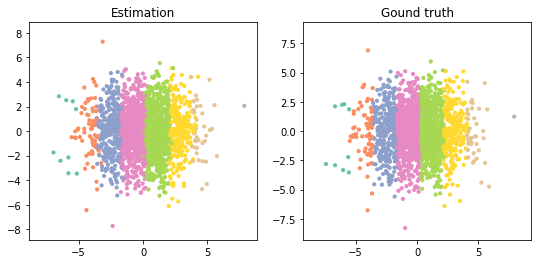

[-0.02424692  0.05323797]
[-0.0201631   0.05378253]


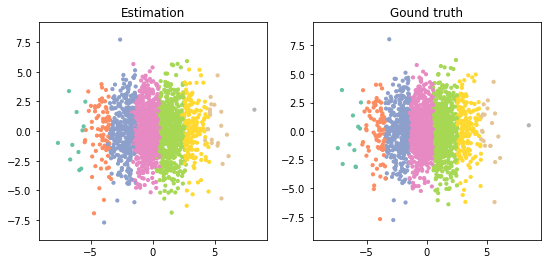

[0.01808896 0.04479197]
[-0.00605356  0.01227205]


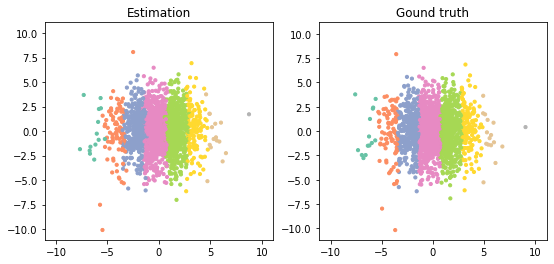

[0.01384275 0.07344343]
[-0.01175092 -0.02421701]


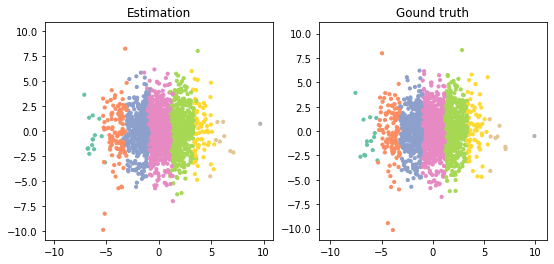

[-0.00258411  0.08228659]
[-0.01335633 -0.05078773]


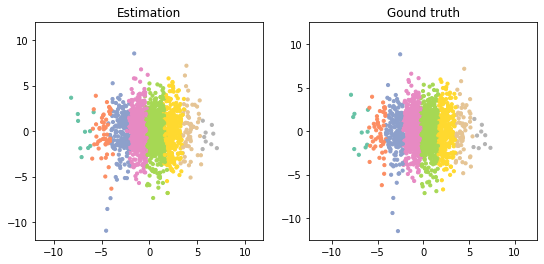

[-0.00801891  0.1465026 ]
[-0.0720356  -0.07230333]


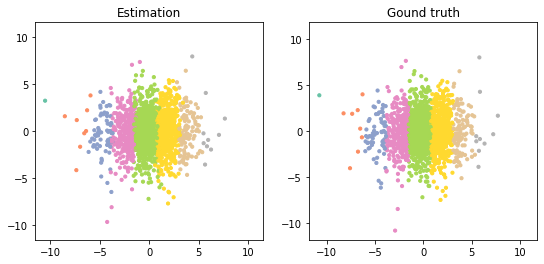

[0.06079598 0.12217273]
[-0.12747196 -0.11168705]


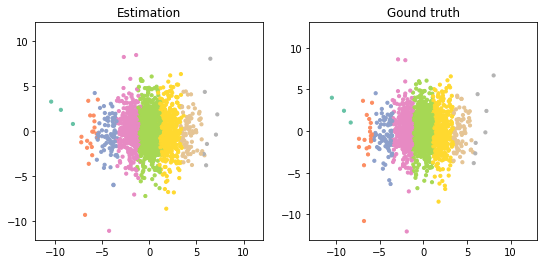

[0.18837967 0.1259447 ]
[-0.24035049 -0.17446889]


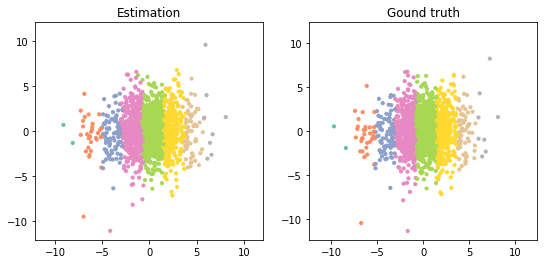

[0.34980245 0.13463365]
[-0.38537857 -0.21186263]


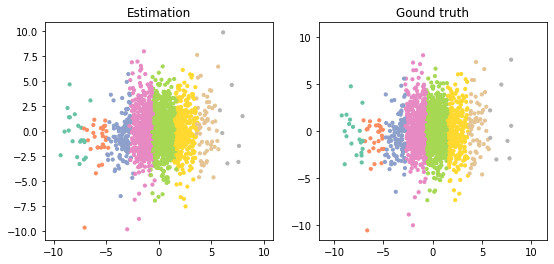

[0.59914863 0.13853233]
[-0.66855307 -0.27744713]


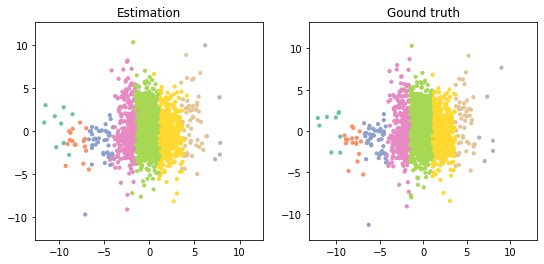

[1.01417118 0.13956407]
[-1.03346883 -0.34732545]


In [38]:
for i in range(T):
    visualize(z_hat=zz,z_true=z[:,[1,0]],start=N*i,end=N*(i+1))
    print(z[N*i:N*i+N//2].mean(axis=0))
    print(z[N*i+N//2:N*i+N].mean(axis=0))


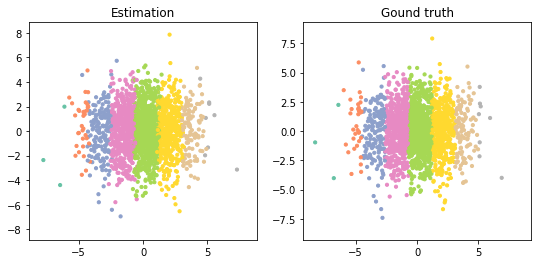

[-0.02424692  0.05323797]
[-0.0201631   0.05378253]


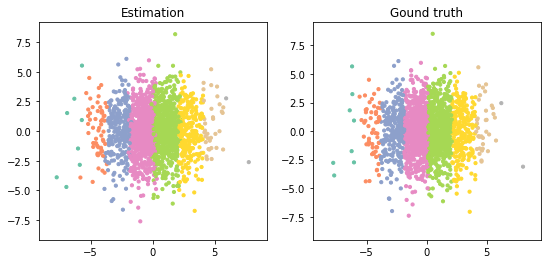

[0.01808896 0.04479197]
[-0.00605356  0.01227205]


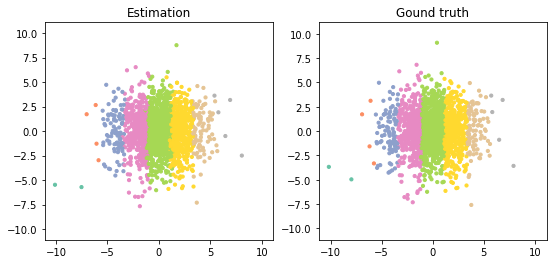

[0.01384275 0.07344343]
[-0.01175092 -0.02421701]


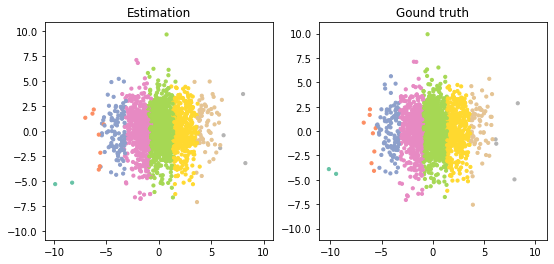

[-0.00258411  0.08228659]
[-0.01335633 -0.05078773]


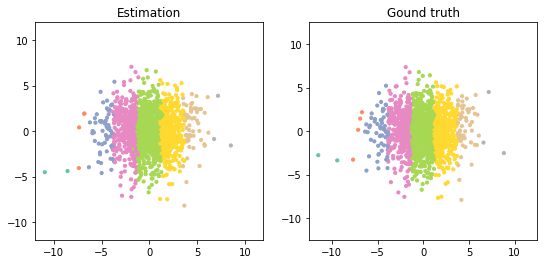

[-0.00801891  0.1465026 ]
[-0.0720356  -0.07230333]


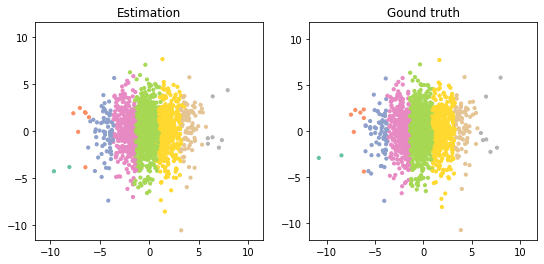

[0.06079598 0.12217273]
[-0.12747196 -0.11168705]


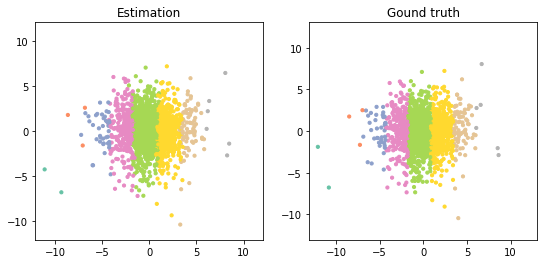

[0.18837967 0.1259447 ]
[-0.24035049 -0.17446889]


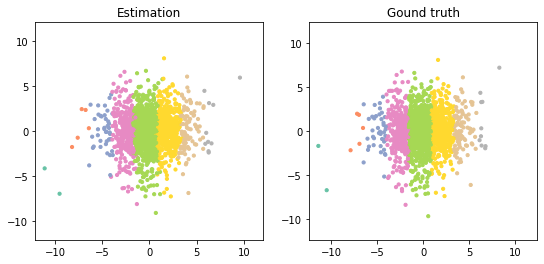

[0.34980245 0.13463365]
[-0.38537857 -0.21186263]


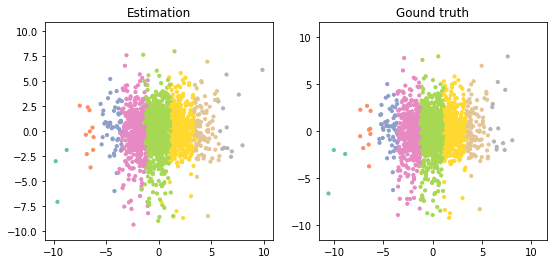

[0.59914863 0.13853233]
[-0.66855307 -0.27744713]


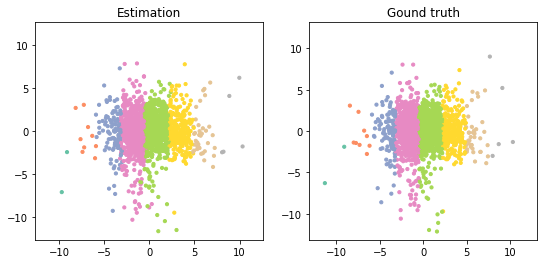

[1.01417118 0.13956407]
[-1.03346883 -0.34732545]


In [39]:
for i in range(T):
    visualize(z_hat=zz,z_true=z[:,[0,1]],start=N*i,end=N*(i+1))
    print(z[N*i:N*i+N//2].mean(axis=0))
    print(z[N*i+N//2:N*i+N].mean(axis=0))


In [40]:
for i in range(T-1):
#     corr = zz[N*i:N*(i+1)].transpose()@zz[N*(i+1):N*(i+2)]
#     print(corr.round(1))
    d1=zz[N*i:N*(i+1)]
    d2=zz[N*(i+1):N*(i+2)]
    c1=d1-(d1.mean(axis=0))[np.newaxis,:]
    c2=d2-(d2.mean(axis=0))[np.newaxis,:]
    R,_ = orthogonal_procrustes(c1,c2)
    print(np.diag(R).round(2))
print('-------------------------')
for i in range(T-2):
#     corr = zz[N*i:N*(i+1)].transpose()@zz[N*(i+1):N*(i+2)]
#     print(corr.round(1))
    d1=zz[N*i:N*(i+1)]
    d2=zz[N*(i+2):N*(i+3)]
    c1=d1-(d1.mean(axis=0))[np.newaxis,:]
    c2=d2-(d2.mean(axis=0))[np.newaxis,:]
    R,_ = orthogonal_procrustes(c1,c2)
    print(np.diag(R).round(2))

[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
-------------------------
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]


In [41]:
model.para

Parameter containing:
tensor([[ 9.8791,  0.9755],
        [ 9.8791,  0.4975],
        [-0.5125,  1.9945]], device='cuda:0', requires_grad=True)

In [42]:
# for i in range(T-1):
#     corr = zz[N*i:N*(i+1)].transpose()@zz[N*(i+1):N*(i+2)]
#     print(corr.round(1))
# #     R,_ = orthogonal_procrustes(zz[N*i:N*(i+1)],zz[N*(i+1):N*(i+2)])
# #     print(np.diag(R))

In [43]:
init_z = zz
init_para = model.para.detach().cpu().numpy()

In [44]:
init_para

array([[ 9.8791065 ,  0.97550744],
       [ 9.8791065 ,  0.4974993 ],
       [-0.5124998 ,  1.9944981 ]], dtype=float32)

# Step 3

In [47]:
def run(optimizer,index,fixed):
    for epoch in range(1,1000):
        loss = train(optimizer=optimizer,index=index,fixed=fixed)
#         if optimizer.param_groups[0]['lr']<0.0001:
#             break
#         if epoch%1111==0 and epoch>111111:
#             tt = epoch%T
#             z_hat, p_hat = model()
#             z_hat = z_hat.detach().cpu().numpy()
#             p_hat = p_hat.detach().cpu().numpy().round(2)
#             caption_dict = {'E':epoch,
#                             'T':tt,
#                             'a':p_hat[0,1],
#                             'd':p_hat[2,1],
#                             'gw':p_hat[1,1],
#                             'gb':p_hat[2,0],
# #                             's':round(math.exp(p_hat[0,0])**0.5,1),
# #                             't':round(math.exp(p_hat[1,0])**0.5,1),
#                            'lr':round(optimizer.param_groups[0]['lr'],2),
#                            'loss':round(loss,1)}
#             start = tt*N
#             end = (tt+1)*N
#             visualize(z_hat=z_hat[:,:2],z_true=z[:,[1,0]],start=start,end=end,caption=str(caption_dict))
    return loss

In [48]:
model = ClsnaModelCongress(device,N,T,ar_pair,Aw,Ab,new_at_t,DIM).to(device)
with torch.no_grad():       
    model.z[:,:] = torch.from_numpy(init_z).to(device)
    model.para[:,:] = torch.from_numpy(init_para).to(device)
optimizer = torch.optim.SGD([
    {'params': model.z, "momentum": MOM, "lr": LR},
    {'params': model.para, "momentum": 0.0, "lr":LR_P}
    ])    
logL = train(optimizer)

In [49]:
delta_var = 0.05

In [ ]:
parad = {'alpha':(0,1),'delta':(2,1),'gw':(1,1),'gb':(2,0)}
var_list = []
for key, value in parad.items():
    model = ClsnaModelCongress(device,N,T,ar_pair,Aw,Ab,new_at_t,DIM).to(device)
    with torch.no_grad():       
        model.z[:,:] = torch.from_numpy(init_z).to(device)
        model.para[:,:] = torch.from_numpy(init_para).to(device)
    optimizer = torch.optim.SGD([
    {'params': model.z, "momentum": MOM, "lr": LR},
    {'params': model.para, "momentum": 0.0, "lr":LR_P}
    ])
    newlogL=run(optimizer,value,init_para[value[0],value[1]]+delta_var)
    print("--------------------------------")
    print(key,delta_var/(newlogL-logL)**0.5/2**0.5)
    var_hat = delta_var/(newlogL-logL)**0.5/2**0.5
    var_list.append(round(var_hat,4))

--------------------------------
alpha 0.001688255520826245


In [52]:
var_list

[0.0017, 0.0016, 0.0085, 0.0078]

In [ ]:
init_para = init_para.round(3)
printdict = {'a':init_para[0,1],'d':init_para[2,1],'gw':init_para[1,1],'gb':init_para[2,0]}
print(printdict)

In [ ]:
for i in range(T-1):
#     corr = zz[N*i:N*(i+1)].transpose()@zz[N*(i+1):N*(i+2)]
#     print(corr.round(1))
    d1=zz[N*i:N*(i+1)]
    d2=zz[N*(i+1):N*(i+2)]
    c1=d1-(d1.mean(axis=0))[np.newaxis,:]
    c2=d2-(d2.mean(axis=0))[np.newaxis,:]
    R,_ = orthogonal_procrustes(c1,c2)
    print(np.diag(R).round(2))

In [ ]:
import csv   
fields=var_list
with open('var001', 'a') as f:
    writer = csv.writer(f)
    writer.writerow(fields)

In [ ]:
import csv   
fields=list(printdict.values())
with open('theta001', 'a') as f:
    writer = csv.writer(f)
    writer.writerow(fields)